In [335]:
import pandas as pd 
import numpy as np
import time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import KernelPCA
from sklearn.metrics import log_loss
%config InlineBackend.figure_format='retina'

In [296]:
train=pd.read_csv('/Users/tarunayroy/Desktop/ML2/Project/train.csv')
test=pd.read_csv('/Users/tarunayroy/Desktop/ML2/Project/test.csv')

In [64]:
train.head()

,problem_id,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v969,v970,v971,v972,v973,v974,v975,v976,v977,target
0,0,0.35,0.36,0.77,0.42,0.48,0.12,0.43,0.49,0.19,...,0.77,0.57,0.56,0.40,0.75,0.08,0.14,0.43,0.88,0
1,0,0.12,0.17,0.38,0.43,0.57,0.09,0.11,0.58,0.35,...,0.07,0.59,0.06,0.17,0.09,0.04,0.04,0.45,0.14,1
2,0,0.67,0.16,0.85,0.41,0.57,0.27,0.83,0.73,0.26,...,0.24,0.42,0.57,0.58,0.37,0.01,0.10,0.38,0.06,1
3,0,0.70,0.20,0.62,0.41,0.41,0.10,0.80,0.52,0.82,...,0.04,0.52,0.25,0.07,0.23,0.04,0.76,0.41,0.59,1
4,0,0.72,0.75,0.74,0.42,0.41,0.76,0.34,0.72,0.06,...,0.81,0.41,0.16,0.03,0.21,0.10,0.12,0.53,0.30,1


In [26]:
X = train.iloc[:, 0:-1]
y = train.iloc[:, -1]

In [4]:
train['problem_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [5]:
train['target'].value_counts()

0    4124
1    3175
2     729
3     255
4      19
Name: target, dtype: int64

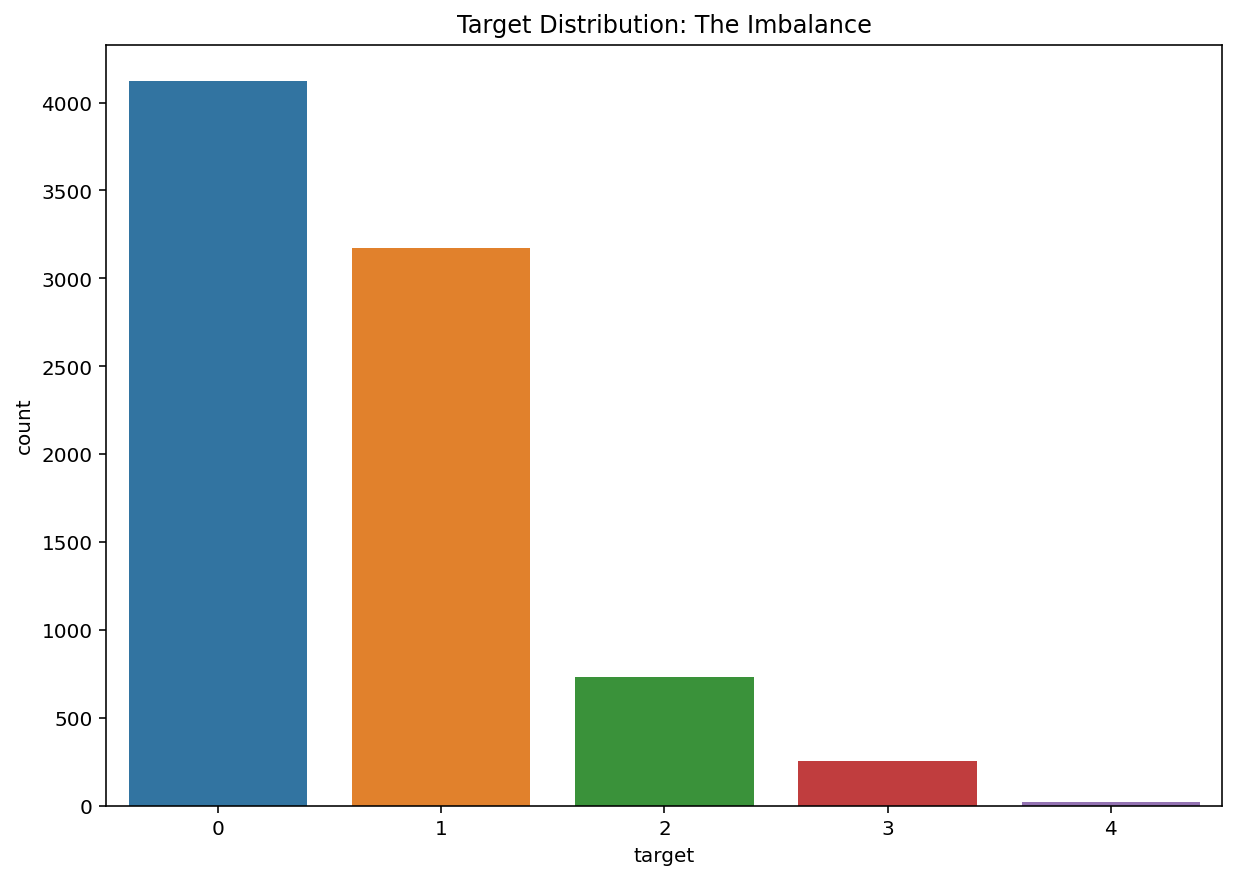

In [376]:
fig,ax=plt.subplots(1,figsize=(10,7))
ax.set_title("Target Distribution: The Imbalance")
sns.countplot(x=train['target'])
plt.savefig("Target.png")
plt.show()

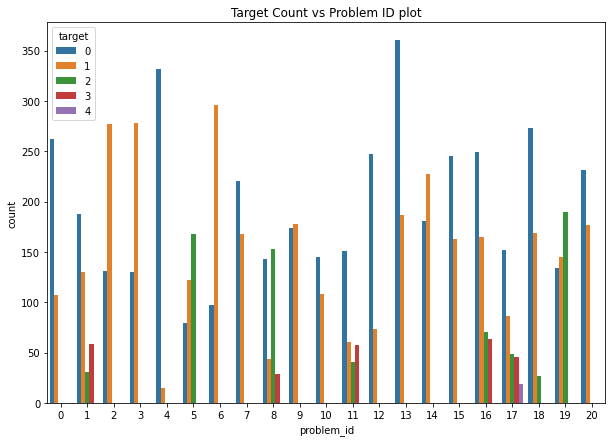

In [89]:
fig,ax=plt.subplots(1,figsize=(10,7))
ax.set_title("Target Count vs Problem ID plot")
sns.countplot(x='problem_id',hue='target',data=train)
plt.show()

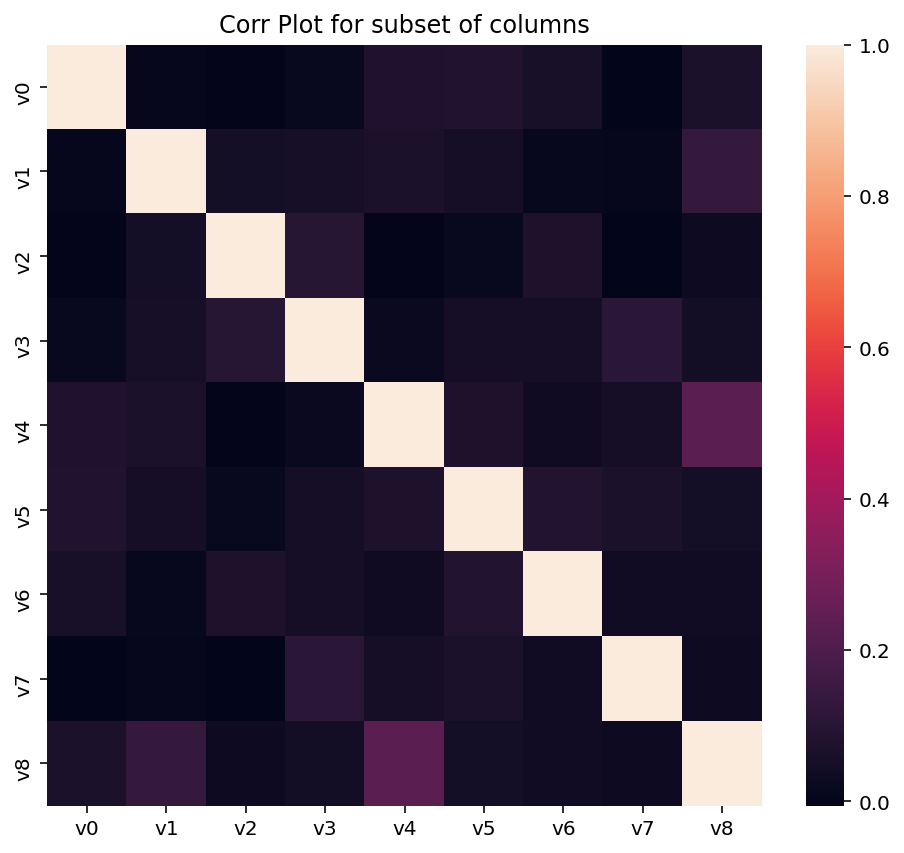

In [356]:
fig,ax=plt.subplots(1,figsize=(8,7))
ax.set_title("Corr Plot for subset of columns",fontdict={'fontsize':12})
sns.heatmap(train[train.columns[1:10]].corr())
plt.show()

## Dimensionality reduction using PCA

We try to reduce the dimensionality of the vectors using PCA (leaving out Problem ID for now)

In [83]:
total_explained_variance=[]
n_components=[]
for i in range(1,50):
    pca = PCA(n_components=i,svd_solver='full')
    X_pca = pca.fit_transform(X[1:])
    total_explained_variance.append(np.sum(pca.explained_variance_))
    n_components.append(i)

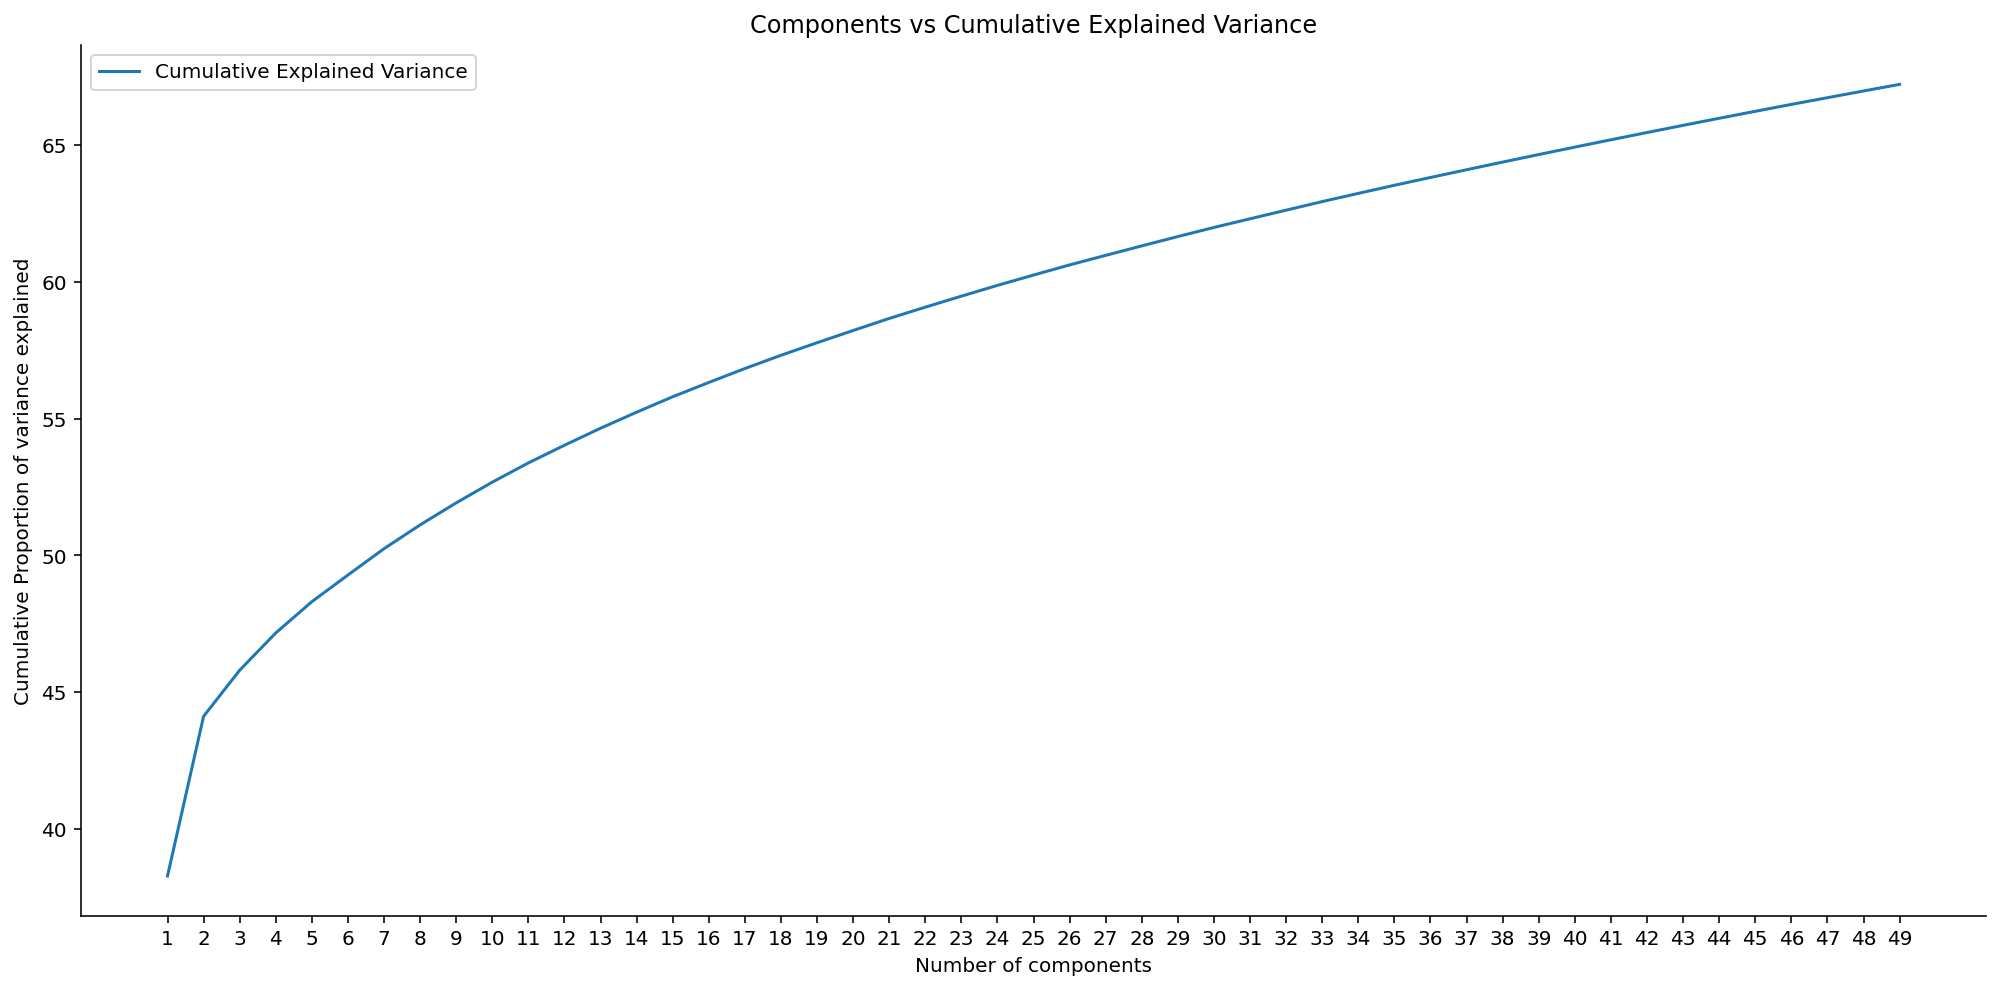

In [379]:
fig,ax=plt.subplots(1,figsize=(14,7))
ax.set_xlabel('Number of components')
ax.set(xticks=n_components)
ax.set_title("Components vs Cumulative Explained Variance")
ax.set_ylabel("Cumulative Proportion of variance explained")
sns.lineplot(x=n_components,y=total_explained_variance,label='Cumulative Explained Variance',ax=ax)
sns.despine(right = True)
plt.tight_layout()
plt.savefig("pca.png")
plt.show()

With 29 components describe 65% of the data. However there is still information lost. This likely might not work well during modelling. Lets try some other ways for dimensionality Reduction such as LDA in the pipeline.

# Statistical Modelling 

## Linear Discriminant Analysis + XgBoost

In [390]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y,random_state=69)

In [391]:
lda=LinearDiscriminantAnalysis(n_components=4)
X_lda=lda.fit_transform(X_train.iloc[:,1:],y_train)

In [392]:
X_train_with_lda=np.hstack((np.array(X_train.iloc[:,:1]),X_lda))

In [395]:
# n_components cannot be larger than min(n_features, n_classes - 1). Since wee have 4 classes we look for values between them
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train_with_lda,y_train)
X_val_lda=lda.transform(X_val.iloc[:,1:])
X_val_with_lda=np.hstack((np.array(X_val.iloc[:,:1]),X_val_lda))
y_pred = model.predict(X_val_with_lda)


[18:44:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [396]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.95%


In [398]:
y_val_prob=model.predict_proba(X_val_with_lda)
print("The log loss is:\n\n",log_loss(y_val,y_val_prob))

The log loss is:

 1.0447852015124361


LDA finds the combination of predictors such that between group variance is maximimised in comparison to within group variance.

In [191]:
lda=LinearDiscriminantAnalysis(n_components=4)
lda.fit(X.iloc[:,1:],y)
X_lda=lda.transform(X.iloc[:,1:])
X_with_lda=np.hstack((np.array(X.iloc[:,:1]),X_lda))

In [192]:
model=XGBClassifier(use_label_encoder=False)

In [193]:
model.fit(X_with_lda,y)

[14:28:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [188]:
X_test = test.drop(columns=['target','obs_id'])

In [195]:
X_test_lda=lda.transform(X_test.iloc[:,1:])
X_test_with_lda=np.hstack((np.array(X_test.iloc[:,:1]),X_test_lda))

In [208]:
X_test_with_lda

array([[ 2.        ,  0.49325136,  0.15432215, -1.88430689, -1.9404574 ],
       [ 2.        , -0.04475879,  0.69799088, -0.4418804 ,  0.9156407 ],
       [ 2.        ,  0.72780028,  0.4518307 ,  2.20136829, -2.08250472],
       ...,
       [16.        , -0.08251383, -1.28495101,  0.67779081, -0.05003363],
       [16.        , -0.63242778, -0.55813739,  0.55218858,  0.75238414],
       [16.        ,  0.33198506, -0.54264699,  0.69099403,  0.8343388 ]])

In [196]:
y_pred=model.predict(X_test_with_lda)

In [199]:
submission=pd.DataFrame(y_pred,columns=['target'])
submission=submission.reset_index()
submission=submission.rename(columns={"index":"obs_id"})
submission.to_csv("LDA_submission.csv",index=False)

In [209]:
print("The accuracy on Kaggle was 67.29%. Lets keep trying!")

The accuracy on Kaggle was 67.29%. Lets keep trying!


## LDA + XgBoost + Hyperparameter Tuning

In [213]:
param_dist = {"use_label_encoder": [False],
               "booster": ["gbtree", "gblinear", "dart"],
               "learning_rate": [0.1,0.15, 0.2, 0.3],
               "max_depth": [3,5,10],
               "n_estimators":[50,90,100,150],
               "scale_pos_weight":[300,500,1000]}

In [215]:
model=XGBClassifier()
clf = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_jobs=-1,cv=4)

In [216]:
clf.fit(X_train_with_lda,y_train)

[14:50:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:50:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [217]:
clf.best_score_

0.7613338966945445

In [221]:
pipe=clf.best_estimator_
pipe

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1000, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [223]:
y_pred=pipe.predict(X_test_with_lda)

In [225]:
submission=pd.DataFrame(y_pred,columns=['target'])
submission=submission.reset_index()
submission=submission.rename(columns={"index":"obs_id"})
submission.to_csv("LDA_submission_2.csv",index=False)

In [ ]:
## Decreasing the learning rate and oncreasing the scale_pos_weight to account for weight imbalance
## We also increase the max_depth to 10
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=7,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1,
              objective='mlogloss', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=300, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [277]:
print("The accuracy on Kaggle was 65.29%. Even Lower! This could be because the model is overfitting and also Data Leakage while working on LDA")

The accuracy on Kaggle was 65.29%. Even Lower! This could be because the model is overfitting and also Data Leakage while working on LDA


# XgBoost  + PCA +Target Mean Encoding

In [243]:
## Trying target encoding
from sklearn.model_selection import KFold

def reg_target_encoding(train, col="device_type", target="click", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    train.reset_index(inplace=True,drop=True)
    kf = KFold(n_splits=splits, shuffle=False)
    new_col = col + "_" + "mean_enc"
    train.loc[:,new_col]=np.NaN
    ### BEGIN SOLUTION
    for train_index,test_index in kf.split(train):
        col_mean=train.loc[train_index].groupby([col])[target].mean()
        train.loc[test_index,new_col]=train.loc[test_index,col].map(col_mean)

    global_mean = train.loc[:, target].mean()
    train[new_col].fillna(global_mean,inplace=True)
def mean_encoding_test(test, train, col="device_type", target="click"):
    """ Computes target enconding for test data.

    This is similar to how we do validation
    """
    new_col = col + "_" + "mean_enc"
    ### BEGIN SOLUTION
    mean_col=train.groupby(col)[target].mean()
    global_mean=train[target].mean()
    train[new_col]=train[col].map(mean_col)
    test[new_col]=test[col].map(mean_col)
    train[new_col].fillna(global_mean,inplace=True)
    test[new_col].fillna(global_mean,inplace=True)

In [363]:
reg_target_encoding(train,col="problem_id",target='target',splits=10)

In [364]:
X = train.drop(columns=['target'])
y = train.iloc[:, -2]

In [365]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y,random_state=69)

In [318]:
param_dist = {"model__use_label_encoder": [False],
               "model__booster": ["gbtree", "gblinear", "dart"],
               "model__learning_rate": [0.1,0.15, 0.2, 0.3],
               "model__max_depth": [3,5,10],
               "model__n_estimators":[50,90,100,150],
               "model__scale_pos_weight":[300,500,1000],
               "PCA__n_components":[15,40,50]}

In [319]:
steps = [('Normalization',StandarScaler()),('PCA', KernelPCA(kernel='rbf')),('model', XGBClassifier())]
pipe=Pipeline(steps)

In [320]:
clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, n_jobs=-1,cv=4)

In [321]:
clf.fit(X_train,y_train)

[17:06:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('PCA', KernelPCA(kernel='rbf')),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                         

In [322]:
clf.best_estimator_

Pipeline(steps=[('PCA', KernelPCA(kernel='rbf', n_components=15)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='dart',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=300,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
    

In [323]:
clf.best_score_

0.6953765694929024

In [324]:
pipe=clf.best_estimator_

In [325]:
pipe.fit(X_train,y_train)

[17:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('PCA', KernelPCA(kernel='rbf', n_components=15)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='dart',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=300,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
    

In [326]:
y_pred=pipe.predict(X_val)

In [327]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.44%


In [328]:
y_prob=pipe.predict_proba(X_val)
print("The log loss of the problem is ",log_loss(y_val,y_prob))

The log loss of the problem is  0.6580086517877191


In [358]:
pipe.fit(X,y)

[18:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('PCA', KernelPCA(kernel='rbf', n_components=15)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='dart',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=300,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
    

In [367]:
mean_encoding_test(test,train,col="problem_id",target='target')

In [370]:
X_test = test.drop(columns=['target','obs_id'])

In [371]:
y_pred=pipe.predict(X_test)

In [372]:
submission=pd.DataFrame(y_pred,columns=['target'])
submission=submission.reset_index()
submission=submission.rename(columns={"index":"obs_id"})
submission.to_csv("PCA_with_XgBoost.csv",index=False)

71% accuracy prediction! 

## XgBoost with all Estimators

In [297]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y,random_state=69)

In [298]:
## Decreasing the learning rate and oncreasing the scale_pos_weight to account for weight imbalance
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=7,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1,
              objective='mlogloss', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=300, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [299]:
model.fit(X_train, y_train)

/Users/tarunayroy/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:40:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=300, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Validation Accuracy is 72.31% This is the best model!

In [300]:
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

In [301]:
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.07%


In [305]:
y_prob=model.predict_proba(X_val)
print("The log loss of the problem is ",log_loss(y_val,y_prob))

The log loss of the problem is  0.7447204926620532


In [306]:
model.fit(X,y)

In [307]:
y_pred= model.predict(X_test)

In [308]:
submission=pd.DataFrame(y_pred,columns=['target'])
submission=submission.reset_index()
submission=submission.rename(columns={"index":"obs_id"})
submission.to_csv("third_submission.csv",index=False)

74% accuracy while prediction!